In [20]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])



In [21]:

# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]

# 3 random rows
df.sample(3)

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
24113,31,Private,363130,HS-grad,9,Never-married,Other-service,Unmarried,Black,Male,0,0,18,United-States,<=50K
31490,37,Private,52221,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
8697,43,Self-emp-inc,123490,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K.


In [22]:
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])

In [23]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,3,6,Married-civ-spouse,0,Husband,0,0,0,50,0
1,2,10,Married-civ-spouse,1,Husband,0,0,0,45,0
2,2,10,Never-married,1,Own-child,0,0,0,40,0
3,2,7,Married-civ-spouse,1,Husband,0,0,0,40,0
4,1,9,Never-married,1,Unmarried,0,0,0,35,0
...,...,...,...,...,...,...,...,...,...,...
48836,2,14,Married-civ-spouse,0,Husband,0,0,0,45,1
48837,1,10,Never-married,1,Not-in-family,1,0,0,20,0
48838,3,10,Never-married,0,Unmarried,0,0,0,38,1
48839,2,10,Married-civ-spouse,1,Husband,0,0,0,40,0


In [24]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [25]:
# Will now do feature scaling on Capital-gain and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,3,6,0,0,-0.146733,-0.21878,50,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2,10,1,0,-0.146733,-0.21878,45,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,2,10,1,0,-0.146733,-0.21878,40,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,2,7,1,0,-0.146733,-0.21878,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,9,1,0,-0.146733,-0.21878,35,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,2,14,0,0,-0.146733,-0.21878,45,1,1,0,...,0,0,0,0,0,1,0,0,0,0
48837,1,10,1,1,-0.146733,-0.21878,20,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,3,10,0,0,-0.146733,-0.21878,38,1,0,0,...,0,1,0,0,0,0,0,1,0,0
48839,2,10,1,0,-0.146733,-0.21878,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Statistics=0.934, p=0.000
Sample does not look Gaussian (reject H0)


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


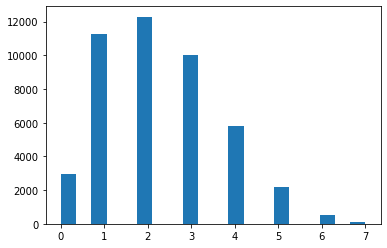

In [26]:
# Converting Age column data from string to numerical.
from scipy.stats import shapiro
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)
plt.hist(df[["Age"]], bins = 20)

stat, p = shapiro(df[["Age"]])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the p-value
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

In [27]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [28]:
# shape of dataset

df.shape

(45222, 21)

In [29]:
# Plotting number of instances of each sex that earn below or above 50k
import numpy as np
import matplotlib.pyplot as plt

# Created copy of X table and added y column back to XVisual, to allow us to carry out below calculations
XVisual = X
XVisual['y'] = y

Sex = []
zero = []
one = []
       
while len(Sex) < 2:
    for i in range(2):
        df_new = XVisual[XVisual['Sex'] == (XVisual['Sex'].value_counts().index.tolist())[i]]
        Sex.append(df_new['Sex'].iloc[0])
        zero.append(df_new['y'].value_counts()[0])
        one.append(df_new['y'].value_counts()[1])
        lowest += 10
            

# Plots bar chart with zero and one next to each other
ind = np.arange(len(Sex))
width = 0.4
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind-0.2, zero, width, color='r', edgecolor = "black")
ax.bar(ind+0.2, one, width, color='b', edgecolor = "black")
ax.set_ylabel('Number of instances')
ax.set_title('Number of instances of income by sex')
ax.legend(labels=['<=50k', '>50k'])
ax.set_xticklabels(['','','Man','','','','Woman'])
# ax.set_xticklabels(['Man','Woman'])
plt.show()

NameError: name 'lowest' is not defined

<ipython-input-36-5df42672a665>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','(10-20]','(20-30]','(30-40]','(40-50]','(50-60]','(60-70]','(70-80]', '(80-90]'])


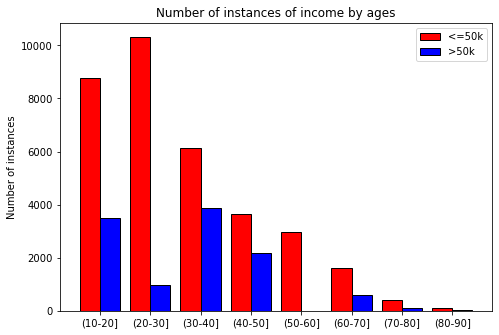

In [ ]:
# Plotting number of instances of each age that earn above or below 50k
import numpy as np
import matplotlib.pyplot as plt

# Created copy of X table and added y column back to XVisual, to allow us to carry out below calculations
XVisual = X
XVisual['y'] = y

ages = []
zero = []
one = []
       
# Goes through 
while len(ages) < 8:
    for i in range(8):
            df_new = XVisual[XVisual['Age'] == (XVisual['Age'].value_counts().index.tolist())[i]]
            ages.append(df_new['Age'].iloc[0])
            zero.append(df_new['y'].value_counts()[0])
            one.append(df_new['y'].value_counts()[1])
            
# Plots bar chart with zero and one next to each other
ind = np.arange(len(ages))
width = 0.4
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind-0.2, zero, width, color='r', edgecolor = "black")
ax.bar(ind+0.2, one, width, color='b', edgecolor = "black")
ax.set_ylabel('Number of instances')
ax.set_title('Number of instances of income by ages')
ax.legend(labels=['<=50k', '>50k'])
ax.set_xticklabels(['','(10-20]','(20-30]','(30-40]','(40-50]','(50-60]','(60-70]','(70-80]', '(80-90]'])
plt.show()

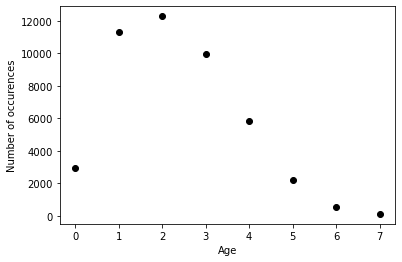

In [ ]:
X['Age'].value_counts().values
X['Age'].value_counts().index.tolist()

# Plotting the number of occurences of each age within the data
plt.scatter(X['Age'].value_counts().index.tolist(), X['Age'].value_counts().values, color='black')
plt.xlabel("Age")
plt.ylabel("Number of occurences")
plt.show()

In [ ]:
X['Sex'].value_counts().values
X['Sex'].value_counts().index.tolist()

# Plotting the number of occurences of each sex within the data
plt.bar(X['Sex'].value_counts().index.tolist(), X['Sex'].value_counts().values, color='black')
plt.xlabel("Sex")
plt.ylabel("Number of occurences")
plt.show()

# Shows that feature scaling is required?

NameError: name 'X' is not defined

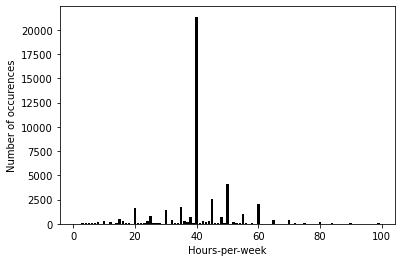

In [ ]:
X['Hours-per-week'].value_counts().values
X['Hours-per-week'].value_counts().index.tolist()

# Plotting the number of occurences of each hours-per-week within the data
plt.bar(X['Hours-per-week'].value_counts().index.tolist(), X['Hours-per-week'].value_counts().values, color='black')
plt.xlabel("Hours-per-week")
plt.ylabel("Number of occurences")
plt.show()

# Shows that feature scaling is required??????

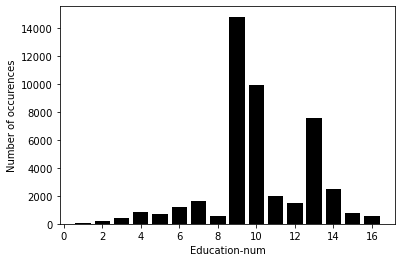

In [ ]:
X['Education-num'].value_counts().values
X['Education-num'].value_counts().index.tolist()

# Plotting the number of occurences of each Education-num within the data
plt.bar(X['Education-num'].value_counts().index.tolist(), X['Education-num'].value_counts().values, color='black')
plt.xlabel("Education-num")
plt.ylabel("Number of occurences")
plt.show()

# Shows that feature scaling is required?